In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import random

# File path
file_path = '/content/news_politics.csv'

# Import the CSV file
df_np = pd.read_csv(file_path)
#Drop all columns with NA values for 'text' column
df_np.columns = ['Unnamed: 0','text', 'id', 'subreddit', 'meta', 'time', 'author',
              'ups', 'downs', 'authorlinkkarma', 'authorkarma', 'authorisgold']

df_np = df_np.dropna(subset=['text'])

#reserve the "no processed" dataframe
df = df_np


# Display the first few rows of the dataframe
print(df.head())
print(df.columns)



df['text'] = df['text'].apply(lambda x: x.lower())  # Lowercase
df['text'] = df['text'].apply(lambda x: re.sub(r'\W+', ' ', x))  # Remove special characters


df['tokens'] = df['text'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['filtered'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

stemmer = PorterStemmer()
df['stemmed'] = df['filtered'].apply(lambda x: [stemmer.stem(word) for word in x])

# Displaying processed data
print(df[['text', 'filtered', 'stemmed']])




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   Unnamed: 0                                               text       id  \
0           0  disclaimer  i think obama should nominate some...  d028c5d   
2           2  either way the process will be dragged out unt...  d026od6   
3           3  republicans have always battled with severe ca...  d026wk3   
4           4  politics were so different back then people on...  d02a3k3   
5           5  equally ridiculous  here s a 1970 law review a...  d025wad   

  subreddit  meta          time              author   ups  downs  \
0  politics  news  1.455651e+09            degausse   3.0    0.0   
2  politics  news  1.455648e+09         cyberspyder   5.0    0.0   
3  politics  news  1.455649e+09               jabb0  15.0    0.0   
4  politics  news  1.455653e+09  Hypertension123456   2.0    0.0   
5  politics  news  1.455647e+09        trash_reason  26.0    0.0   

   authorlinkkarma  authorkarma  authorisgold  
0                1         1941           0.0  
2             1300         6462 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# This is your feature matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df['ups_category'] = ['high' if x >= df['ups'].quantile(0.9) else 'none' if x == 0 else 'ignore' for x in df['ups']]

# Filter out the posts that are not in the 'high' or 'none' categories
df_filtered = df[df['ups_category'].isin(['high', 'none'])]

# Splitting the dataset into training and testing sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_filtered['text'], df_filtered['ups_category'], test_size=0.2, random_state=42)

# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training raw text data
X_train = vectorizer.fit_transform(X_train_raw)

# Transform the testing raw text data
X_test = vectorizer.transform(X_test_raw)


KeyboardInterrupt: ignored

In [9]:
# Fit your logistic regression model
model = LogisticRegression(C=0.1, penalty='l2', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Get feature names from the TF-IDF Vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a DataFrame to view the coefficients alongside feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of coefficients to see the most important features
feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='abs_coefficient', ascending=False)

# Display the top features
print(feature_importance.head(20))


              precision    recall  f1-score   support

        high       0.94      1.00      0.97      1768
        none       1.00      0.72      0.83       365

    accuracy                           0.95      2133
   macro avg       0.97      0.86      0.90      2133
weighted avg       0.95      0.95      0.95      2133

         Feature  Coefficient  abs_coefficient
1094         its     1.704098         1.704098
1070   insurance     1.497978         1.497978
535         date     1.395795         1.395795
1962  supporting     1.365308         1.365308
1828         she    -1.358137         1.358137
956          her    -1.253436         1.253436
2029        they    -1.243920         1.243920
206       attack     1.197598         1.197598
1601       proud     1.178264         1.178264
1380          nt    -1.144758         1.144758
462   considered     1.137561         1.137561
541         deal     1.133974         1.133974
853      georgia     1.125425         1.125425
158           a

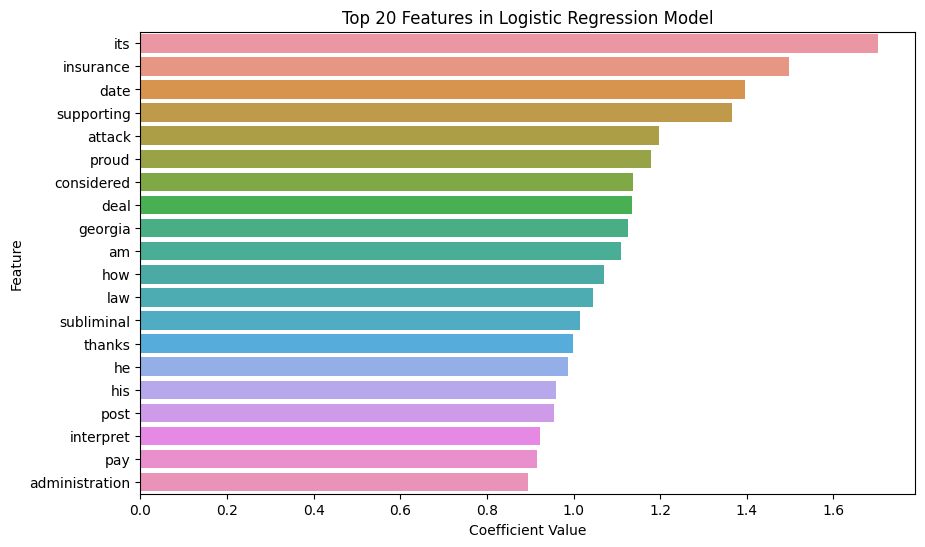

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns


# Visualization of Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.sort_values(by='Coefficient', ascending=False).head(20))
plt.title('Top 20 Features in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

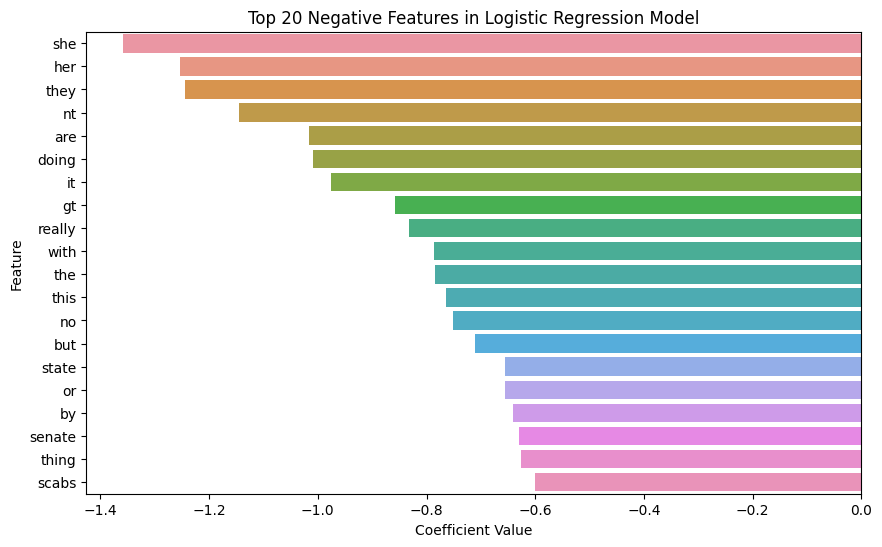

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'feature_importance' is your DataFrame with 'Feature' and 'Coefficient' columns
# Selecting top features with the most negative coefficients
top_negative_features = feature_importance.sort_values(by='Coefficient').head(20)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_negative_features)
plt.title('Top 20 Negative Features in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


In [ ]:
#define "texts" variable as to the top 10% of upvotes
texts = df_np[df_np['ups'] >= df_np['ups'].quantile(0.90)]['text']
# Remove empty strings (if necessary)

#Save to a text file
with open('top_10_percent.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [12]:
texts

20       thank you gop for making me think of cruz when...
28       he brings up two random supporters to speak fo...
35       this was actually pretty awesome and holy crap...
36       this is great what a bunch of high energy indi...
44       welcome to the information age where your past...
                               ...                        
94021    somebody does nt want to campaign on not doing...
94022     he advised the president to nominate someone ...
94024    i think it is pretty hilarious that this is be...
94025     if he puts forth someone that we think is in ...
94026    he wo nt be the last to break ranks too many o...
Name: text, Length: 8823, dtype: object

In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [14]:
def fine_tune_gpt2(model_name, train_file, output_dir, num_layers_to_unfreeze):
    # Load GPT-2 model and tokenizer
    model = GPT2LMHeadModel.from_pretrained(model_name)


    tokenizer = GPT2Tokenizer.from_pretrained(model_name)

    # Unfreeze the last num_layers_to_unfreeze layers
    for parameter in model.transformer.h[-num_layers_to_unfreeze:].parameters():
        parameter.requires_grad = True

    # Freeze all other layers
    for parameter in model.transformer.h[:-num_layers_to_unfreeze].parameters():
        parameter.requires_grad = False


# Load training dataset
    train_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=train_file,
        block_size=128)
    # Create data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False)
    # Set training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=1,
        per_device_train_batch_size=8,
        save_steps=10_000,
        save_total_limit=2,
    )
    # Train the model
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )
    trainer.train()
    # Save the fine-tuned model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [ ]:
!pip install accelerate

Name: accelerate
Version: 0.25.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [15]:
# Fine-tune the model
fine_tune_gpt2("gpt2", "top_10_percent.txt", "output", 2)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss


In [16]:
import shutil

shutil.make_archive("/content/output", 'zip', "/content/output")


'/content/output.zip'

In [240]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def generate_text(model_path, prompt, max_length=50):
    # Load the fine-tuned model and tokenizer
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)

    # Encode the input prompt to get tensor
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    # Generate text
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)

    # Decode and return the generated text
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example usage
output_text = generate_text("output", "Clinton is")
print(output_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Clinton is a moderate who has a record of courting the base and courting the base is a sign that she has a serious plan to address the problems that affect the country she leads it in the first place and she has a plan to address the


In [227]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Specify the directory where the fine-tuned model and tokenizer are saved
output_dir = "/content/output"

# Load the fine-tuned model
model = GPT2LMHeadModel.from_pretrained(output_dir)

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)


The rest of this code attempts to use GP3, which unfortunately costs money so I did not pursue further

In [33]:
"""# Import the os package
import os

# Import the openai package
import openai

# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

# Import yfinance as yf
import yfinance as yf

In [48]:
"""import openai as ai
os.environ["OPENAI_API_KEY"] = #### INSERT KEY HERE ####



In [50]:
"""from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who won the world series in 2020?"},
    {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    {"role": "user", "content": "Where was it played?"}
  ]
)

RateLimitError: ignored

In [233]:
"""from transformers import BertModel, BertTokenizer
import torch


In [235]:
"""model_name = "bert-base-uncased"  # You can choose other versions of BERT

model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)


In [234]:
"""inputs = tokenizer("Your input text goes here", return_tensors="pt")


In [236]:
"""with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state


In [239]:
"""sentence_embedding = torch.mean(last_hidden_states, dim=1)
sentence_embedding

tensor([[-6.6709e-02, -1.1770e-01, -1.8137e-01, -2.8853e-01,  1.6586e-02,
         -8.9004e-02,  2.8106e-01,  7.3208e-01, -5.8298e-02,  8.3015e-02,
         -1.9243e-01,  1.2994e-01,  8.9149e-02,  9.8009e-02, -1.4131e-01,
         -1.3601e-01, -5.7288e-02,  3.1526e-01, -4.4419e-01,  3.5809e-01,
          1.1528e-01, -4.5917e-02, -3.9191e-01,  6.6410e-02,  1.0397e+00,
         -2.7306e-01, -3.4348e-01, -3.6029e-01, -8.7926e-01, -4.5825e-01,
         -7.2648e-02, -1.9185e-01, -1.6653e-01,  1.6398e-02, -1.1612e-01,
         -2.6545e-02,  8.1494e-02,  3.6734e-02, -2.6728e-01,  3.3554e-01,
         -7.3512e-01, -1.7825e-01,  3.8584e-01, -1.5204e-01,  4.7883e-01,
         -2.5267e-01,  6.0299e-02,  3.7484e-01, -1.2677e-02,  1.4617e-01,
         -8.0144e-01,  1.6583e-01, -1.9185e-01,  2.0854e-01, -1.3679e-01,
          3.1419e-01,  3.8737e-02, -3.4178e-01, -3.7189e-01, -1.6390e-01,
          3.6404e-01,  2.2611e-01, -1.3281e-01,  2.6943e-02,  9.0606e-02,
          2.9580e-01, -1.4908e-01,  4.